In [1]:
import matplotlib.pyplot as plt   
import numpy as np  

import torch  
from torch import nn, optim  
 

import torch.nn.functional as F  
import torch.optim as optim

import torchvision.utils as vutils  
from torchvision import datasets, transforms 
 
from torchvision.utils import save_image 

In [2]:
batch_size = 32
image_size = 64
 
lr = 0.0002
 
channels = 3

epochs = 100

latentVec = 100
 
beta1 = 0.5
 
ngpu = 1
 
FeaGen = 64
FeaDis = 64

In [3]:
import os
import shutil
dataset_path="/kaggle/input/cuhk-face-sketch-database-cufs/cropped_sketch"
fixed_path = "/kaggle/working/cropped_sketch_fixed"
os.makedirs(fixed_path, exist_ok=True)

# Create a dummy class folder
class_folder = os.path.join(fixed_path, "default_class")
os.makedirs(class_folder, exist_ok=True)

# Move images into the dummy class folder
for img_file in os.listdir(dataset_path):
    img_path = os.path.join(dataset_path, img_file)
    if os.path.isfile(img_path):  # Ensure it's a file
        shutil.copy(img_path, class_folder)

print(f"Dataset restructured at: {fixed_path}")

Dataset restructured at: /kaggle/working/cropped_sketch_fixed


In [4]:
import os
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

 
transform = transforms.Compose([transforms.Resize(image_size), 
                                 
                                transforms.CenterCrop(image_size),
                                transforms.ToTensor(),#convert it to a tensor of normalzid values 0-1
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Dataloader
 
train_data = datasets.ImageFolder("/kaggle/working/cropped_sketch_fixed", transform = transform)
train_loader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=batch_size)

imgs, label = next(iter(train_loader)) 
imgs = imgs.numpy().transpose(0, 2, 3, 1)

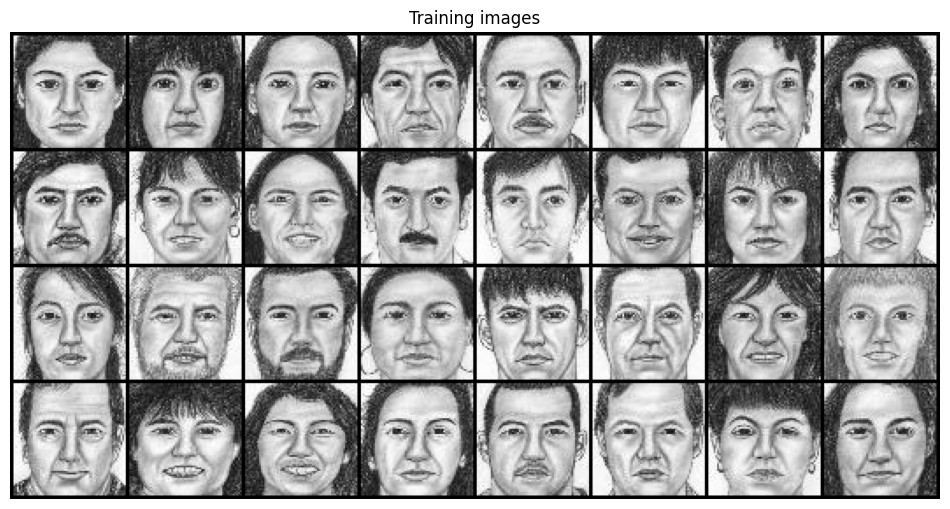

In [5]:
TrainingImages = next(iter(train_loader))
plt.figure(figsize=(12, 10))
plt.axis("off")
plt.title("Training images")
 

 
plt.imshow(np.transpose(vutils.make_grid(TrainingImages[0].to(device)[:64], padding=2, 
                                         normalize=True).cpu(),(1,2,0)))

In [6]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0.0)

# DCGAN

In [7]:
class Generator(nn.Module):
    
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.ConvTranspose2d(latentVec, FeaGen * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(FeaGen * 8),
            nn.ReLU(True),
            # State size. (FeaGen x 8) x 4 x 4 
            nn.ConvTranspose2d(FeaGen * 8, FeaGen * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(FeaGen * 4),
            nn.ReLU(True),
            # State size. (FeaGen x 4) x 8 x 8 
            nn.ConvTranspose2d(FeaGen * 4, FeaGen * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(FeaGen * 2),
            nn.ReLU(True),
            # State size. (FeaGen x 2) x 16 x 16
            nn.ConvTranspose2d(FeaGen * 2, FeaGen, 4, 2, 1, bias=False),
            nn.BatchNorm2d(FeaGen),
            nn.ReLU(True),
            # State size. FeaGen x 32 x 32
            nn.ConvTranspose2d(FeaGen, channels, 4, 2, 1, bias=False),
            nn.Tanh()
        )
        
    def forward(self, input):
        return self.main(input)
    
    
# Create the generator
netG = Generator(ngpu).to(device)

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [8]:
class Discriminator(nn.Module):
    
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is channels x 64 x 64
            nn.Conv2d(channels, FeaDis, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # State size. (FeaDis) x 32 x 32
            nn.Conv2d(FeaDis, FeaDis * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(FeaDis * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # State size. (FeaDis * 2) x 16 x 16
            nn.Conv2d(FeaDis * 2, FeaDis * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(FeaDis * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # State size. (FeaDis * 4) x 8 x 8
            nn.Conv2d(FeaDis * 4, FeaDis * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(FeaDis * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # State size. (FeaDis * 8) x 4 x 4
            nn.Conv2d(FeaDis * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
    def forward(self, input):
           return self.main(input)
    
    
# Create the discriminator
netD = Discriminator(ngpu).to(device)

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [9]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
# the progression of the generator
fixed_noise = torch.randn(64, latentVec, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [10]:
# Lists to keep track of progress
Glosses = []
Dlosses = []
iters = 0
num_epochs = 50

# For each epoch
for epoch in range(num_epochs):
    # For each batch in dataloader
    for i, data in enumerate(train_loader, 0):
        
        # Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ## Train with real batch
        netD.zero_grad()
        realImg = data[0].to(device)
        batch_size = realImg.size(0)
        labels = torch.full((batch_size,), real_label, device=device, dtype=torch.float)
        
        # Validate label shape
        assert labels.shape == (batch_size,), f"Expected labels shape ({batch_size},), got {labels.shape}"
        
        output = netD(realImg).view(-1)  # Shaping to 1D vector
        Real_Loss = criterion(output, labels)  # Calculate loss
        Real_Loss.backward()  # Calculate gradient
        Dx = output.mean().item()  # For monitoring the result
        
        ## Train with fake batch
        # Generate batch of latent vectors
        noise = torch.randn(batch_size, latentVec, 1, 1, device=device)
        fake = netG(noise)
        labels.fill_(fake_label)
        output = netD(fake.detach()).view(-1)  # Match output shape
        Fake_Loss = criterion(output, labels)
        Fake_Loss.backward()
        D_G1 = output.mean().item()
        
        # Add the gradients from the all-real and all-fake batches
        DisLoss = Real_Loss + Fake_Loss
        optimizerD.step()
        
        # Update G network: maximize log(D(G(z)))
        netG.zero_grad()
        labels.fill_(real_label)  # Fake labels are real for generator cost
        output = netD(fake).view(-1)  # Match output shape
        GLoss = criterion(output, labels)
        GLoss.backward()
        D_G2 = output.mean().item()
        optimizerG.step()
        
        # Output training stats
        if iters % 60 == 0:
            print('[Epoch %d/%d] [Batch %d/%d] [D Loss: %.4f] [G Loss: %.4f] [D(x): %.4f] [D(G(z)): %.4f/%.4f]' 
                  % (epoch, num_epochs, i, len(train_loader), DisLoss.item(), GLoss.item(), Dx, D_G1, D_G2))
            
            ValidImage = netG(fixed_noise)
        
        iters += 1
            
        # Save Losses
        Glosses.append(GLoss.item())
        Dlosses.append(DisLoss.item())


[Epoch 0/50] [Batch 0/38] [D Loss: 1.5781] [G Loss: 2.9856] [D(x): 0.3830] [D(G(z)): 0.2900/0.0645]
[Epoch 1/50] [Batch 22/38] [D Loss: 0.0065] [G Loss: 8.5342] [D(x): 0.9975] [D(G(z)): 0.0040/0.0003]
[Epoch 3/50] [Batch 6/38] [D Loss: 0.0000] [G Loss: 39.6654] [D(x): 1.0000] [D(G(z)): 0.0000/0.0000]
[Epoch 4/50] [Batch 28/38] [D Loss: 0.0000] [G Loss: 39.8129] [D(x): 1.0000] [D(G(z)): 0.0000/0.0000]
[Epoch 6/50] [Batch 12/38] [D Loss: 0.0000] [G Loss: 39.7378] [D(x): 1.0000] [D(G(z)): 0.0000/0.0000]
[Epoch 7/50] [Batch 34/38] [D Loss: 0.0000] [G Loss: 39.3420] [D(x): 1.0000] [D(G(z)): 0.0000/0.0000]
[Epoch 9/50] [Batch 18/38] [D Loss: 0.0000] [G Loss: 39.5746] [D(x): 1.0000] [D(G(z)): 0.0000/0.0000]
[Epoch 11/50] [Batch 2/38] [D Loss: 0.0000] [G Loss: 38.9554] [D(x): 1.0000] [D(G(z)): 0.0000/0.0000]
[Epoch 12/50] [Batch 24/38] [D Loss: 0.0000] [G Loss: 39.2130] [D(x): 1.0000] [D(G(z)): 0.0000/0.0000]
[Epoch 14/50] [Batch 8/38] [D Loss: 0.0000] [G Loss: 38.0576] [D(x): 1.0000] [D(G(z))

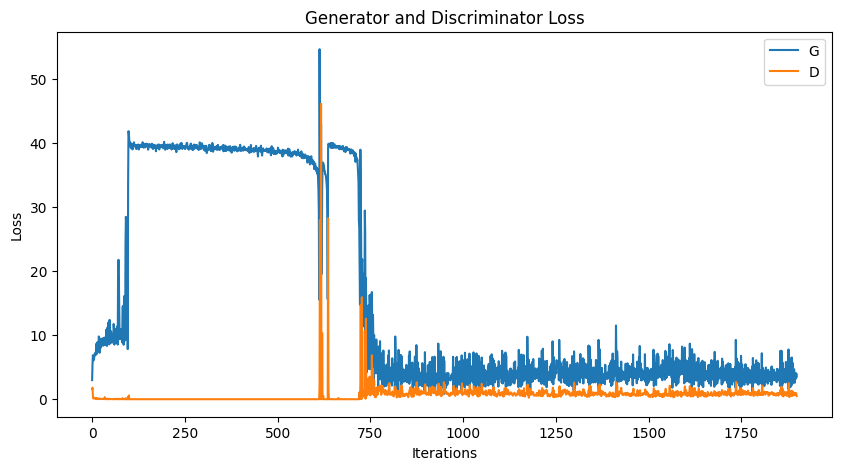

In [11]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss")
plt.plot(Glosses,label="G")
plt.plot(Dlosses,label="D")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

# WGAN

update discriminator and remove Sigmoid function
maxmize score of real  image and minimize score of real image

In [12]:
 
import torch.nn.utils.spectral_norm as spectral_norm
class Generator(nn.Module):
    def __init__(self, ngpu, latentVec, FeaGen, channels):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # First layer: Latent vector to larger feature maps
            spectral_norm(nn.ConvTranspose2d(latentVec, FeaGen * 8, 4, 1, 0, bias=False)),
            nn.BatchNorm2d(FeaGen * 8),
            nn.ReLU(inplace=True),
            # State size: (FeaGen * 8) x 4 x 4

            # Second layer: Increase feature maps
            spectral_norm(nn.ConvTranspose2d(FeaGen * 8, FeaGen * 4, 4, 2, 1, bias=False)),
            nn.BatchNorm2d(FeaGen * 4),
            nn.ReLU(inplace=True),
            # State size: (FeaGen * 4) x 8 x 8

            # Third layer: Further increase feature maps
            spectral_norm(nn.ConvTranspose2d(FeaGen * 4, FeaGen * 2, 4, 2, 1, bias=False)),
            nn.BatchNorm2d(FeaGen * 2),
            nn.ReLU(inplace=True),
            # State size: (FeaGen * 2) x 16 x 16

            # Fourth layer: Continue upsampling
            spectral_norm(nn.ConvTranspose2d(FeaGen * 2, FeaGen, 4, 2, 1, bias=False)),
            nn.BatchNorm2d(FeaGen),
            nn.ReLU(inplace=True),
            # State size: (FeaGen) x 32 x 32

            # Fifth layer: Upsample and reduce to final feature size
            spectral_norm(nn.ConvTranspose2d(FeaGen, channels, 4, 2, 1, bias=False)),
            nn.Tanh()
            # Output size: (channels) x 64 x 64
        )
        
    def forward(self, input):
        return self.main(input)


In [13]:
class Discriminator(nn.Module):
    def __init__(self, ngpu, FeaDis, channels):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # Input: (channels) x 64 x 64
            spectral_norm(nn.Conv2d(channels, FeaDis, 4, 2, 1, bias=False)),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            # State size: (FeaDis) x 32 x 32

            # Second layer
            spectral_norm(nn.Conv2d(FeaDis, FeaDis * 2, 4, 2, 1, bias=False)),
            nn.BatchNorm2d(FeaDis * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            # State size: (FeaDis * 2) x 16 x 16

            # Third layer
            spectral_norm(nn.Conv2d(FeaDis * 2, FeaDis * 4, 4, 2, 1, bias=False)),
            nn.BatchNorm2d(FeaDis * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            # State size: (FeaDis * 4) x 8 x 8

            # Fourth layer
            spectral_norm(nn.Conv2d(FeaDis * 4, FeaDis * 8, 4, 2, 1, bias=False)),
            nn.BatchNorm2d(FeaDis * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            # State size: (FeaDis * 8) x 4 x 4

            # Output layer
            spectral_norm(nn.Conv2d(FeaDis * 8, 1, 4, 1, 0, bias=False))
        )
        
    def forward(self, input):
        return self.main(input)


In [14]:
netG = Generator(ngpu, latentVec, FeaGen, channels).to(device)
netD = Discriminator(ngpu, FeaDis, channels).to(device)
optimizerD = torch.optim.Adam(netD.parameters(), lr=0.0001, betas=(0.0, 0.9))
optimizerG = torch.optim.Adam(netG.parameters(), lr=0.0002, betas=(0.0, 0.9))
# Initialize weights
netG.apply(weights_init)
netD.apply(weights_init)

# Print Models
print(netG)
print(netD)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [15]:
# Lists to keep track of progress
Glosses = []
Dlosses = []
iters = 0
num_epochs = 70

# For each epoch
for epoch in range(num_epochs):
    for i, data in enumerate(train_loader, 0):
        
        # Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        netD.zero_grad()
        
        realImg = data[0].to(device)
        batch_size = realImg.size(0)
        noise = torch.randn(batch_size, latentVec, 1, 1, device=device)
        fake = netG(noise)

        # Real batch
        labels = torch.full((batch_size,), real_label, device=device, dtype=torch.float)
        output = netD(realImg).view(-1)  # Shaping to 1D vector
        Real_Loss = -torch.mean(output)  # WGAN uses Wasserstein loss
        Real_Loss.backward()

        # Fake batch
        labels.fill_(fake_label)
        output = netD(fake.detach()).view(-1)  # Match output shape
        Fake_Loss = torch.mean(output)  # WGAN uses Wasserstein loss
        Fake_Loss.backward()
        
        # Total discriminator loss (Wasserstein loss)
        D_Loss = Real_Loss + Fake_Loss
        D_loss = D_Loss
        optimizerD.step()

        # Gradient clipping for the discriminator
        for p in netD.parameters():
            p.data.clamp_(-0.01, 0.01)  # Clamp discriminator weights

        # Update G network: maximize log(D(G(z)))
        if i % 5 == 0:  # Train the generator less frequently (e.g., every 5 steps)
            netG.zero_grad()
            output = netD(fake).view(-1)  # Match output shape
            G_Loss = -torch.mean(output)  # WGAN uses Wasserstein loss
            G_Loss.backward()
            optimizerG.step()

        # Output training stats
        if iters % 60 == 0:
            print('[Epoch %d/%d] [Batch %d/%d] [D Loss: %.4f] [G Loss: %.4f] [W Distance: %.4f]'
                  % (epoch, num_epochs, i, len(train_loader), D_loss.item(), G_Loss.item(), -D_loss.item()))

        iters += 1

        # Save Losses
        Glosses.append(G_Loss.item())
        Dlosses.append(D_loss.item())


[Epoch 0/70] [Batch 0/38] [D Loss: 0.4353] [G Loss: 0.0001] [W Distance: -0.4353]
[Epoch 1/70] [Batch 22/38] [D Loss: -0.6263] [G Loss: 0.2180] [W Distance: 0.6263]
[Epoch 3/70] [Batch 6/38] [D Loss: -1.2755] [G Loss: 0.6571] [W Distance: 1.2755]
[Epoch 4/70] [Batch 28/38] [D Loss: -1.4354] [G Loss: 0.7448] [W Distance: 1.4354]
[Epoch 6/70] [Batch 12/38] [D Loss: -1.5206] [G Loss: 0.7901] [W Distance: 1.5206]
[Epoch 7/70] [Batch 34/38] [D Loss: -1.5721] [G Loss: 0.8045] [W Distance: 1.5721]
[Epoch 9/70] [Batch 18/38] [D Loss: -1.5684] [G Loss: 0.7986] [W Distance: 1.5684]
[Epoch 11/70] [Batch 2/38] [D Loss: -1.5320] [G Loss: 0.7980] [W Distance: 1.5320]
[Epoch 12/70] [Batch 24/38] [D Loss: -1.5736] [G Loss: 0.8123] [W Distance: 1.5736]
[Epoch 14/70] [Batch 8/38] [D Loss: -1.5568] [G Loss: 0.8042] [W Distance: 1.5568]
[Epoch 15/70] [Batch 30/38] [D Loss: -1.4662] [G Loss: 0.6569] [W Distance: 1.4662]
[Epoch 17/70] [Batch 14/38] [D Loss: -1.6313] [G Loss: 0.7925] [W Distance: 1.6313]
[Ep

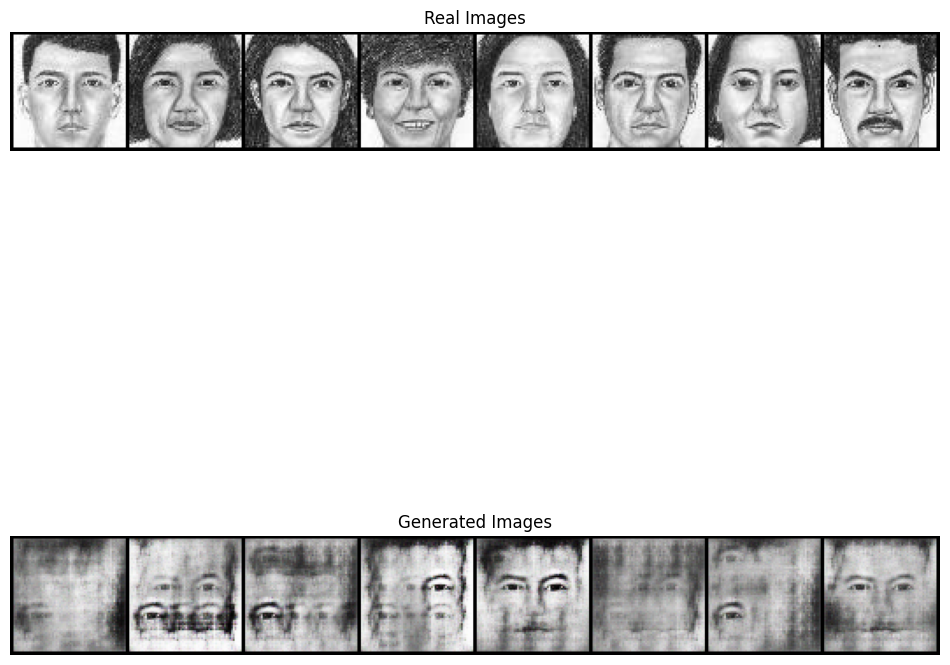

In [16]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils

# Number of images to display (make sure it's an even number to align real and fake images)
num_images = 8  # For example, 8 images (4 real, 4 generated)

# Select a batch of real images from your test dataset
real_batch = next(iter(train_loader))  # Assuming train_loader is your DataLoader
real_images = real_batch[0].to(device)  # Real images from the batch

# Generate random latent vectors (noise)
fixed_noise = torch.randn(num_images, latentVec, 1, 1, device=device)

# Generate images from the noise using the trained generator
with torch.no_grad():
    generated_images = netG(fixed_noise).detach().cpu()  # Move generated images to CPU for plotting

# Create a grid of real images
real_grid = vutils.make_grid(real_images[:num_images], padding=2, normalize=True).cpu()  # Move to CPU

# Create a grid of generated images
generated_grid = vutils.make_grid(generated_images, padding=2, normalize=True).cpu()  # Move to CPU

# Plot the real and generated images side by side
plt.figure(figsize=(12, 12))

# Real images
plt.subplot(2, 1, 1)  # 2 rows, 1 column, first subplot
plt.imshow(real_grid.permute(1, 2, 0))  # Convert from CxHxW to HxWxC
plt.title("Real Images")
plt.axis('off')  # Hide axes

# Generated images
plt.subplot(2, 1, 2)  # 2 rows, 1 column, second subplot
plt.imshow(generated_grid.permute(1, 2, 0))  # Convert from CxHxW to HxWxC
plt.title("Generated Images")
plt.axis('off')  # Hide axes

plt.show()


# VAE

In [46]:
import tensorflow as tf
from tensorflow.keras import layers

# Downsampling block with ReLU
def down_block(inputs, filters, size, apply_batch_normalization=True):
    x = layers.Conv2D(filters, kernel_size=size, padding='same', strides=2)(inputs)
    if apply_batch_normalization:
        x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    return x

# Upsampling block with Dropout
def up_block(inputs, filters, size, dropout=False):
    x = layers.Conv2DTranspose(filters, kernel_size=size, padding='same', strides=2)(inputs)
    if dropout:
        x = layers.Dropout(0.3)(x)
    x = layers.ReLU()(x)
    return x

def build_model(SIZE):
    encoder_input = layers.Input(shape=(SIZE, SIZE, 3))
    
    # Encoder
    x = down_block(encoder_input, 16, 4, False)
    x = down_block(x, 32, 4)
    x = down_block(x, 64, 4, False)
    x = down_block(x, 128, 4)
    x = down_block(x, 256, 4)
    encoder_output = down_block(x, 512, 4)
    
    # Decoder
    x = up_block(encoder_output, 512, 4, dropout=True)
    x = up_block(x, 256, 4)
    x = up_block(x, 128, 4, dropout=True)
    x = up_block(x, 64, 4)
    x = up_block(x, 32, 4)
    x = up_block(x, 16, 4)
    
    # Final output layer
    decoder_output = layers.Conv2DTranspose(3, (2, 2), strides=1, padding='same')(x)
    
    return tf.keras.Model(encoder_input, decoder_output)

# Define SIZE for 64x64 images
SIZE = 64

# Build the model
model = build_model(SIZE)

# Compile with reconstruction loss for image generation
 
# Display the model summary
model.summary()

 


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_36 (Conv2D)                   │ (None, 32, 32, 16)          │             784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_12 (ReLU)                      │ (None, 32, 32, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_37 (Conv2D)                   │ (None, 16, 16, 32)          │           8,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_24               │ (None, 16, 16, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_13 (ReLU)                      │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_38 (Conv2D)                   │ (None, 8, 8, 64)            │          32,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_14 (ReLU)                      │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_39 (Conv2D)                   │ (None, 4, 4, 128)           │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_25               │ (None, 4, 4, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_15 (ReLU)                      │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_40 (Conv2D)                   │ (None, 2, 2, 256)           │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_26               │ (None, 2, 2, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_16 (ReLU)                      │ (None, 2, 2, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_41 (Conv2D)                   │ (None, 1, 1, 512)           │       2,097,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_27               │ (None, 1, 1, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_17 (ReLU)                      │ (None, 1, 1, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_42                  │ (None, 2, 2, 512)           │       4,194,816 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 2, 2, 512)           │              

 Total params: 9,787,939 (37.34 MB)

 Trainable params: 9,786,083 (37.33 MB)

 Non-trainable params: 1,856 (7.25 KB)

In [47]:
import tensorflow as tf
import torch
import numpy as np
from tensorflow.keras.optimizers import Adam

# Convert PyTorch DataLoader (with no labels) to TensorFlow Dataset
def convert_to_tf_dataset_no_labels(pytorch_loader):
    images = []
    
    for imgs, _ in pytorch_loader:  # No labels are used, only images
        imgs = imgs.numpy().transpose(0, 2, 3, 1)  # Convert to NHWC format (batch, height, width, channels)
        images.append(imgs)
    
    images = np.concatenate(images, axis=0)
    
    # Check the shape of the data before creating the TensorFlow dataset
    print(f"Shape of images before converting to TensorFlow dataset: {images.shape}")
    
    # Create a TensorFlow Dataset with just images
    tf_dataset = tf.data.Dataset.from_tensor_slices(images)
    
    return tf_dataset

# Assuming `train_loader` is your PyTorch DataLoader (images without labels)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)

# Convert PyTorch DataLoader to TensorFlow Dataset
train_dataset = convert_to_tf_dataset_no_labels(train_loader)

 
train_dataset = train_dataset.map(lambda x: (x, x))

 
train_dataset = train_dataset.shuffle(buffer_size=1000).batch(32)

 


#  learning rate
learning_rate = 0.001


optimizer = Adam(learning_rate=learning_rate)

# Compile the model with the custom optimizer
model.compile(optimizer=optimizer, loss = 'mean_absolute_error',
              metrics = ['acc'])

# Training loop (using images only)
history = model.fit(train_dataset, epochs=150)


Shape of images before converting to TensorFlow dataset: (1194, 64, 64, 3)
Epoch 1/150
38/38 ━━━━━━━━━━━━━━━━━━━━ 12s 105ms/step - acc: 0.2596 - loss: 0.4897
Epoch 2/150
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - acc: 0.3050 - loss: 0.3458
Epoch 3/150
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - acc: 0.3382 - loss: 0.2855
Epoch 4/150
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - acc: 0.3576 - loss: 0.2511
Epoch 5/150
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - acc: 0.3562 - loss: 0.2350
Epoch 6/150
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - acc: 0.3430 - loss: 0.2216
Epoch 7/150
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - acc: 0.3415 - loss: 0.2124
Epoch 8/150
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - acc: 0.3457 - loss: 0.2074
Epoch 9/150
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - acc: 0.3426 - loss: 0.2009
Epoch 10/150
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - acc: 0.3358 - loss: 0.1955
Epoch 11/150
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - acc: 0.3419 - loss: 0.1948
Epoch 12/150
38/38 ━━━━━━━━━━━

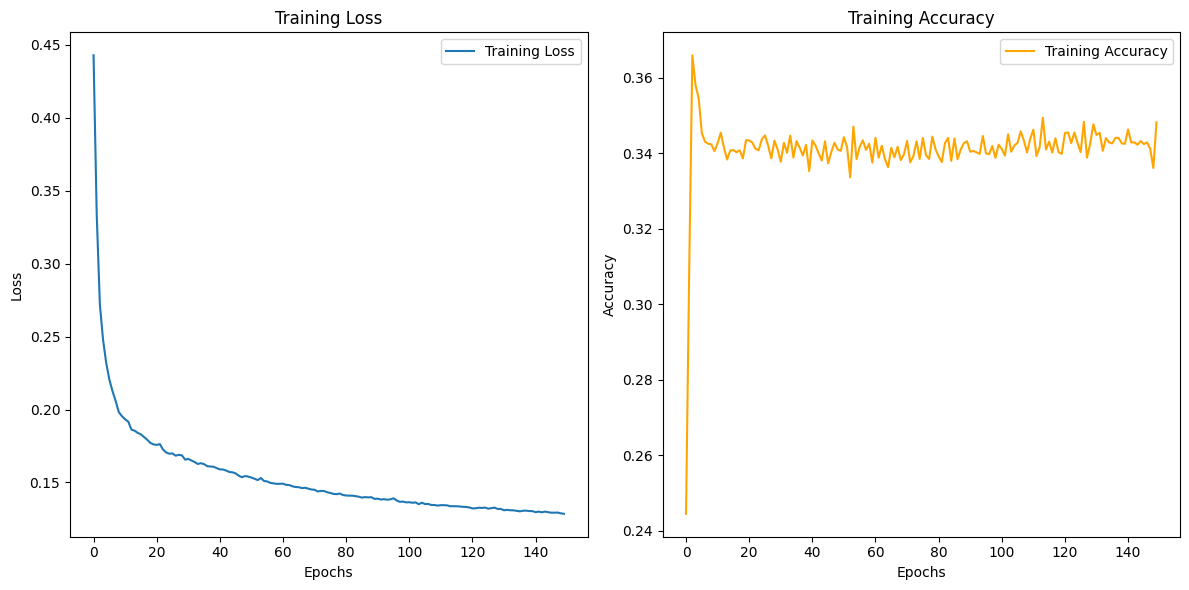

In [49]:
# Access the loss and accuracy from the history
loss = history.history['loss']
# For accuracy, use 'acc' if it's a classification problem, or 'accuracy' in newer versions
accuracy = history.history.get('acc', None)

# Plotting the training loss
plt.figure(figsize=(12, 6))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(loss, label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy if it's available
if accuracy is not None:
    plt.subplot(1, 2, 2)
    plt.plot(accuracy, label='Training Accuracy', color='orange')
    plt.title('Training Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

plt.tight_layout()
plt.show()